## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [48]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
sns.color_palette('Paired')

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn import tree
from sklearn import svm


from sklearn.model_selection import GridSearchCV
%matplotlib inline

### Data Preparation
First of all, I will take a look at the mailout training dataset, and use the ETL functions notebook that I created before to clean the data.

In [2]:
mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)

In [3]:
mailout_train.shape

(42962, 367)

In [4]:
mailout_train.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [5]:
mailout_train.LNR.nunique()

42962

Rerun ETL Functions notebook, replace azdias data to mailout training data to obtain the cleaned dataset.

In [6]:
mailout_train_clean = pd.read_csv('./data/mailout_train_cleaned.csv', index_col=0)

In [7]:
mailout_train_clean.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2.0,1.0,8.0,8.0,NaN,0.0,1.0,13.0,3.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1.0,4.0,13.0,13.0,1.0,0.0,2.0,1.0,2.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1.0,1.0,9.0,7.0,NaN,0.0,NaN,1.0,4.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2.0,1.0,6.0,6.0,4.0,0.0,2.0,4.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2.0,1.0,9.0,9.0,NaN,0.0,1.0,44.0,3.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [8]:
mailout_train_clean.shape

(33837, 358)

In [9]:
mailout_train_clean.dtypes.value_counts()

float64    266
int64       88
object       4
dtype: int64

In [10]:
mailout_train_clean.RESPONSE.value_counts()

0    33421
1      416
Name: RESPONSE, dtype: int64

In [11]:
X = mailout_train_clean.drop(['RESPONSE'], axis=1)
y = mailout_train_clean['RESPONSE']

#### Feature Engineering
Similarly to unsupervised learning, I will use a feature engineering function to deal with categorical columns and missing values, then scale the data.

In [12]:
labels = mailout_train_clean[['LNR', 'RESPONSE']]

In [13]:
# create function for feature engineering process
def feature_eng_mailout(mailout_clean):
    '''
    Feature engineering for clean mailout dataset
    
    INPUT:
         mailout_clean: mailout DataFrame from ETL part
    
    OUTPUT:
         mailout: mailout DataFrame for supervised learning models
    '''
    
    print('.......... Deal With Categorical Columns ..........')
    # drop some categorical columns
    drop_cat_col = ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']
    mailout = mailout_clean.drop(drop_cat_col, axis=1)

    # create dummy variables for the remaining categorical columns
    mailout = pd.concat([mailout.drop(['OST_WEST_KZ'], axis=1), pd.get_dummies(mailout['OST_WEST_KZ'])], axis=1)
    
    print('.......... Impute Missing Variables ..........')
    # inpute missing variables with the most frequent value
    imputer = SimpleImputer(strategy='most_frequent')

    mailout = pd.DataFrame(imputer.fit_transform(mailout), columns = mailout.columns)
    
    print('.......... Scale Data ..........')
    # perfrom feature scalling
    # scale data
    scaler = StandardScaler()

    scaler.fit(mailout)

    mailout = pd.DataFrame(scaler.transform(mailout), columns = mailout.columns)

    print('.......... Complete ..........')
    return mailout

In [14]:
X = feature_eng_mailout(X)

.......... Deal With Categorical Columns ..........
.......... Impute Missing Variables ..........
.......... Scale Data ..........
.......... Complete ..........


In [15]:
print(X.shape, y.shape)

(33837, 355) (33837,)


### Logistic Regression
My first approach is to use a logistic regression model to work on the prediction and compute the `Area Under the Receiver Operating Characteristic Curve (ROC AUC)` from the prediction scores.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=10)

In [21]:
clf_lr = LogisticRegression(random_state=10).fit(X_train, y_train)

/Users/nanliwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
y_pred = clf_lr.predict(X_test)


In [23]:
# accuracy score
#clf_lr.score(X_test, y_test)
accuracy_score(y_test, y_pred)

0.9877364066193853

In [24]:
# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(6685, 0, 83, 0)

In [25]:
# roc_auc_score
pred_prob = clf_lr.predict_proba(X_test)[:,1]
roc_auc_score(y_test, pred_prob)

0.6914148741563111

In [27]:
# learning curve for different training and test sets combinations
train_sizes, train_scores, test_scores = learning_curve(
        LogisticRegression(random_state=10), X, y, scoring = 'roc_auc', train_sizes=np.linspace(.2, 1.0, 5))


/Users/nanliwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nanliwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [28]:
for train_size, cv_train_scores, cv_test_scores in zip(
    train_sizes, train_scores, test_scores
):
    print(f"{train_size} samples were used to train the model")
    print(f"The average train accuracy is {cv_train_scores.mean():.2f}")
    print(f"The average test accuracy is {cv_test_scores.mean():.2f}")

5413 samples were used to train the model
The average train accuracy is 0.98
The average test accuracy is 0.59
10827 samples were used to train the model
The average train accuracy is 0.91
The average test accuracy is 0.62
16241 samples were used to train the model
The average train accuracy is 0.88
The average test accuracy is 0.66
21655 samples were used to train the model
The average train accuracy is 0.87
The average test accuracy is 0.68
27069 samples were used to train the model
The average train accuracy is 0.85
The average test accuracy is 0.68


In [29]:
# cross cvalidation score
cv_scores = cross_val_score(LogisticRegression(random_state=10), X, y, cv=5, scoring='roc_auc')

/Users/nanliwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nanliwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [30]:
cv_scores

array([0.66610015, 0.65236279, 0.69973611, 0.70347819, 0.6833528 ])

### Other Classification Models
In this part, I will try different models, and calculate their auc_roc_scores for comparison.

In [31]:
X.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,O,W
0,-1.651014,0.417025,-0.291086,-0.942968,-0.420497,-0.628015,-0.221416,-0.823952,0.499397,-0.045367,...,-0.747344,-0.824640,0.736728,0.245776,-0.522548,0.208541,0.855641,0.584506,-0.557221,0.557221
1,-1.650693,-1.220349,1.488724,0.281576,0.739960,-0.628015,-0.221416,0.532742,-0.365228,-1.012052,...,-0.747344,-0.824640,-0.411397,0.245776,1.449454,-1.426210,0.855641,-0.647380,-0.557221,0.557221
2,-1.650493,-1.220349,-0.291086,-0.698059,-0.652589,-0.628015,-0.221416,-0.823952,-0.365228,0.921317,...,-0.137255,-0.426482,0.736728,0.245776,-1.015549,0.208541,-1.168714,0.584506,1.794619,-1.794619
3,-1.663171,0.417025,-0.291086,-1.432785,-0.884681,0.587553,-0.221416,0.532742,-0.149072,0.921317,...,1.998057,3.156947,0.736728,0.245776,-1.508550,0.208541,0.855641,0.584506,-0.557221,0.557221
4,-1.650212,0.417025,-0.291086,-0.698059,-0.188406,-0.628015,-0.221416,-0.823952,2.733010,-0.045367,...,-0.747344,-0.824640,0.736728,0.245776,-0.522548,0.208541,-1.168714,-0.647380,-0.557221,0.557221


In [32]:
mailout_train_clean.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2.0,1.0,8.0,8.0,NaN,0.0,1.0,13.0,3.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1.0,4.0,13.0,13.0,1.0,0.0,2.0,1.0,2.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1.0,1.0,9.0,7.0,NaN,0.0,NaN,1.0,4.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2.0,1.0,6.0,6.0,4.0,0.0,2.0,4.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2.0,1.0,9.0,9.0,NaN,0.0,1.0,44.0,3.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=10)

In [34]:
def fit_models(model, X_train, y_train, X_test, y_test):
    '''
    Fit a classification model on X_tain, y_tain, and make predictions on X_test, y_test, 
    and then calculate roc_auc scores.

    INPUT:
      model: a classification model
      X_train: training data
      y_tain: taining labels
      X_test: test data
      y_test: test labels
    
    OUTPUT:
      score: roc_auc for the model  
      time: time used to fit the model
    
    '''
    start = time.time()
    model = model.fit(X_train, y_train)
    
    score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

    end = time.time()
    time_elapsed = end - start
    
    return score, time_elapsed

In [35]:
models = [('LogisticRegression', LogisticRegression(random_state=10)),
         ('DecisionTreeClassifier', tree.DecisionTreeClassifier(random_state=10)),
         ('RandomForestClassifier', RandomForestClassifier(random_state=10)),
         ('SupportVectorMachines', svm.SVC(random_state=10, probability=True)),
         ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=10)),
         ('AdaBoostClassifier', AdaBoostClassifier(random_state=10)),
         ('XGBClassifier',xgb.XGBClassifier(random_state=10))]

In [36]:
results = {'Model':[],
          'AUCROC':[],
          'Time':[]}

for mode_name, model in models:
    roc_auc, time_used  = fit_models(model, X_train, y_train, X_test, y_test)
    results['Model'].append(mode_name)
    results['AUCROC'].append(roc_auc)
    results['Time'].append(time_used)

/Users/nanliwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC,Time
0,LogisticRegression,0.691415,0.735743
1,DecisionTreeClassifier,0.508873,1.85149
2,RandomForestClassifier,0.629866,6.15423
3,SupportVectorMachines,0.643002,627.24936
4,GradientBoostingClassifier,0.774327,40.581642
5,AdaBoostClassifier,0.766851,11.303409
6,XGBClassifier,0.764564,1.364126


From the results table, I can conclude that `Gradient Boosting Classifier`, `Ada Boost Classifier`, and `XGB Classifier` have the best performance regarding auc_roc_scores. `Support Vector Machines` took the longest time, almost 10 minutes, but the performance wasn't satisfactory.

### Gride Search
In this part, I will turn parameters for algorithms that have better performance from the last part using `Grid Search` method.

#### Gradient Boosting Classifier

In [61]:
GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [42]:

gbc_parameters = {'learning_rate': [0.1, 0.2], 'n_estimators': [100, 150],
            'max_depth': [3, 5], 'min_samples_split': [2,4]}        
        
gbc_grid = GridSearchCV(estimator=GradientBoostingClassifier(random_state=10), param_grid=gbc_parameters,
            scoring = 'roc_auc', verbose=2)


gbc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100; total time=  31.9s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100; total time=  31.0s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100; total time=  27.7s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100; total time=  27.7s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100; total time=  27.8s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=150; total time=  41.1s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=150; total time=  41.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=150; total time=  44.5s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=150; total time=  45.7s
[CV] END learning_rate=0.1, max_depth=3, min_sam

GridSearchCV(estimator=GradientBoostingClassifier(random_state=10),
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 5],
                         'min_samples_split': [2, 4],
                         'n_estimators': [100, 150]},
             scoring='roc_auc', verbose=2)

In [45]:
# get the best estimator
gbc_best = gbc_grid.best_estimator_

print('Best Score fore Gradient Boosting Classifier:', gbc_grid.best_score_)
print('Best Parameters for Gradient Bosting Classifier: ', gbc_grid.best_params_)

Best Score fore Gradient Boosting Classifier: 0.7782373649578282
Best Parameters for Gradient Bosting Classifier:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}


In [46]:
# get predictions
gbc_preds = gbc_best.predict_proba(X_test)[:,1]

print('ROC Score on Test Set: {:.4f}'.format(roc_auc_score(y_test, gbc_preds)))

ROC Score on Test Set: 0.7868


In [49]:
# save model
pickle.dump(gbc_best, open('./data/gbc_best.pickle.dat', 'wb'))

In [52]:
# gbc_best.feature_importances_

In [54]:
feature_importances = gbc_best.feature_importances_

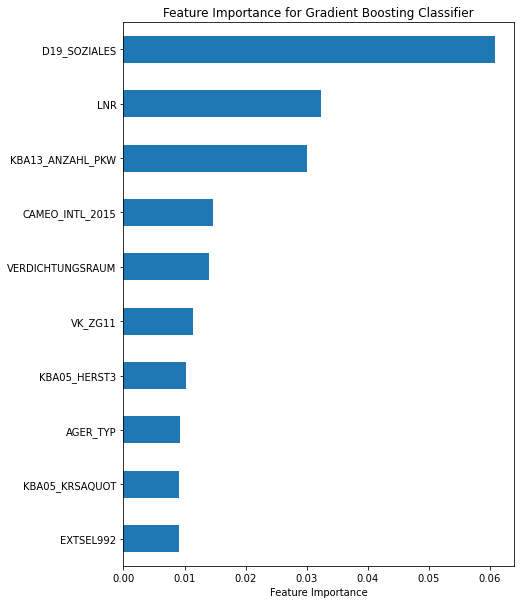

In [57]:
pd.Series(feature_importances, X.columns).sort_values()[-10:].plot(kind='barh', figsize=(7,10))
plt.title('Feature Importance for Gradient Boosting Classifier')
plt.xlabel('Feature Importance')
plt.savefig('FeatureImportance_gbc.png', dpi=500);

#### Ada Boost Classifier

In [62]:
AdaBoostClassifier().get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [58]:
ada_parameters = {'learning_rate': [0.1, 0.5, 1], 'n_estimators': [50, 100],
            'algorithm':['SAMME.R']}        
        
ada_grid = GridSearchCV(estimator=AdaBoostClassifier(random_state=10), param_grid=ada_parameters,
            scoring = 'roc_auc', verbose=2)


ada_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=50; total time=   7.2s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=50; total time=   7.4s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=50; total time=   7.5s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=50; total time=   7.4s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=50; total time=   7.4s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=100; total time=  14.0s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=100; total time=  14.6s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=100; total time=  14.0s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=100; total time=  14.3s
[CV] END algorithm=SAMME.R, learning_rate=0.1, n_estimators=100; total time=  14.8s
[CV] END algorithm=SAMME.R, learning_rate=0.5, n_estimators=50; total time=   8.0s
[CV] END algorithm=SAM

GridSearchCV(estimator=AdaBoostClassifier(random_state=10),
             param_grid={'algorithm': ['SAMME.R'],
                         'learning_rate': [0.1, 0.5, 1],
                         'n_estimators': [50, 100]},
             scoring='roc_auc', verbose=2)

In [63]:
# get the best estimator
ada_best = ada_grid.best_estimator_

print('Best Score fore Ada Boosting Classifier:', ada_grid.best_score_)
print('Best Parameters for Ada Bosting Classifier: ', ada_grid.best_params_)

Best Score fore Ada Boosting Classifier: 0.773432288037718
Best Parameters for Ada Bosting Classifier:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 50}


In [64]:
# get predictions
ada_preds = ada_best.predict_proba(X_test)[:,1]

print('ROC Score on Test Set: {:.4f}'.format(roc_auc_score(y_test, ada_preds)))

ROC Score on Test Set: 0.7925


In [65]:
# save model
pickle.dump(ada_best, open('./data/ada_best.pickle.dat', 'wb'))

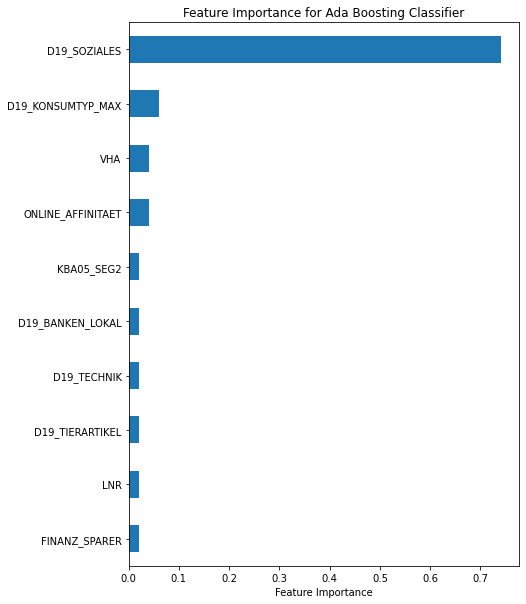

In [66]:
feature_importances = ada_best.feature_importances_
pd.Series(feature_importances, X.columns).sort_values()[-10:].plot(kind='barh', figsize=(7,10))
plt.title('Feature Importance for Ada Boosting Classifier')
plt.xlabel('Feature Importance')
plt.savefig('FeatureImportance_gbc.png', dpi=500);

#### XGBoost Classifier

In [67]:
xgb.XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [68]:
xgb_parameters = {'learning_rate': [0.01, 0.1], 'n_estimators': [100, 200],
            'max_depth': [3, 5], 'gamma': [0.1, 1.0]}    
        
xgb_grid = GridSearchCV(estimator=xgb.XGBClassifier(random_state=10), param_grid=xgb_parameters,
            scoring = 'roc_auc', verbose=2)


xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.1s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.6s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.2s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.0s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.0s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   1.8s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   1.7s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   1.8s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   1.8s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   1.8s
[CV] END gamma=0.1, learning_rate=0.01,

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
        

In [69]:
# get the best estimator
xgb_best = xgb_grid.best_estimator_

print('Best Score fore XGBoost Classifier:', xgb_grid.best_score_)
print('Best Parameters for XGBoost Classifier: ', xgb_grid.best_params_)

Best Score fore XGBoost Classifier: 0.7803134106723855
Best Parameters for XGBoost Classifier:  {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [70]:
# get predictions
xgb_preds = xgb_best.predict_proba(X_test)[:,1]

print('ROC Score on Test Set: {:.4f}'.format(roc_auc_score(y_test, xgb_preds)))

ROC Score on Test Set: 0.7742


In [71]:
# save model
pickle.dump(xgb_best, open('./data/xgb_best.pickle.dat', 'wb'))

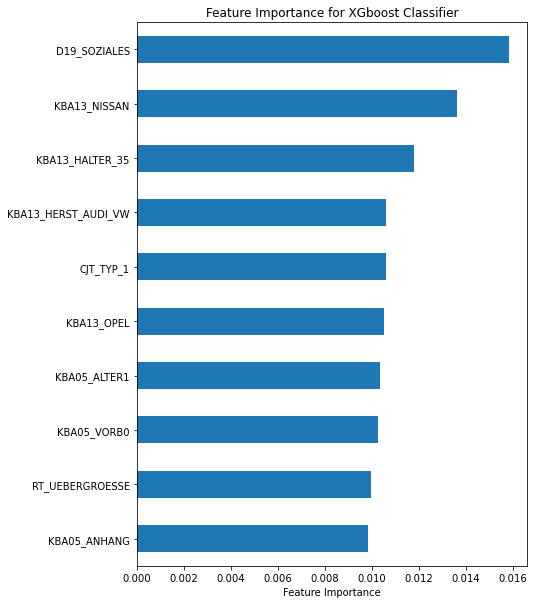

In [72]:
feature_importances = xgb_best.feature_importances_
pd.Series(feature_importances, X.columns).sort_values()[-10:].plot(kind='barh', figsize=(7,10))
plt.title('Feature Importance for XGboost Classifier')
plt.xlabel('Feature Importance')
plt.savefig('FeatureImportance_gbc.png', dpi=500);